In [107]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text, DecisionTreeRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
import graphviz 
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [123]:
df = pd.read_csv('ShootingSplits_HeatCheckTour.csv')
df = df.dropna(axis=1)
print(df.shape)
df.head(3)

(704, 47)


,Unnamed: 0,YEAR,TEAM NO,TEAM ID,TEAM,CONF,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,...,THREES D SHARE RANK,SEED,ROUND,POWER,PATH,WINS,POOL VALUE,POOL S-RANK,NCAA S-RANK,POWER-PATH
0,0,2024,1079,2,Akron,MAC,97.2,6.8,90.6,5.6,...,170,14,64,54.3,79.8,0,2.0,54,54,-25.5
1,1,2024,1078,3,Alabama,SEC,81.9,9.5,89.2,7.3,...,164,4,4,77.3,66.4,4,39.0,13,16,10.9
2,2,2024,1077,8,Arizona,P12,91.2,11.9,89.3,5.9,...,219,2,16,86.2,64.6,2,91.8,2,6,21.6


In [109]:
[df['rating'], cutoffs] = pd.qcut(df.ROUND, 2, labels = ['B', 'G'], retbins = True)
cutoffs

array([ 1., 48., 64.])

In [110]:
df_train = df[df['YEAR'] != 2024]
df_test = df[df['YEAR'] == 2024]
# X_train = df_train.drop(['Unnamed: 0','YEAR','TEAM NO','TEAM ID','TEAM','CONF','WINS','ROUND', 'POWER-PATH'],axis=1)
X_train = df_train.drop(['rating', 'Unnamed: 0', 'YEAR', 'TEAM NO', 'TEAM ID', 'TEAM', 'CONF', 'SEED', 'ROUND', 'POWER', 'PATH', 'POOL VALUE', 'POOL S-RANK', 'NCAA S-RANK', 'POWER-PATH', 'WINS'], axis=1)

# X_test = df_test.drop(['Unnamed: 0','YEAR','TEAM NO','TEAM ID','TEAM','CONF','WINS','ROUND', 'POWER-PATH'],axis=1)
X_test = df_test.drop(['rating', 'Unnamed: 0', 'YEAR', 'TEAM NO', 'TEAM ID', 'TEAM', 'CONF', 'SEED', 'ROUND', 'POWER', 'PATH', 'POOL VALUE', 'POOL S-RANK', 'NCAA S-RANK', 'POWER-PATH', 'WINS'], axis=1)

y_train = df_train.rating
y_test = df_test.rating
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

In [111]:
lr = LogisticRegression(solver='lbfgs', max_iter=100000)
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.678125

In [128]:
lr.coef_

array([[-0.20560486,  0.10502379, -0.22955412, -0.60077382, -0.6936894 ,
         0.38228487,  0.26766646, -0.27676916,  0.05584539, -0.01584699,
        -0.42371018, -0.21308166, -0.09633385, -0.41481758,  0.20796272,
         0.47866685, -0.22248071,  0.0839576 ,  0.18055715, -0.00495702,
        -0.03138038,  0.35132007,  0.09088017,  0.2183551 ,  0.16350074,
        -0.10422138,  0.60640816, -0.26673   ,  0.09596634, -0.4431521 ,
         0.14886899, -0.62874396]])

In [127]:
coef = pd.DataFrame()
coef['coeffs'] = lr.coef_
coef['feature'] = X_test.columns

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [112]:
lr.score(X_test, y_test)

0.671875

In [113]:
df.columns

Index(['Unnamed: 0', 'YEAR', 'TEAM NO', 'TEAM ID', 'TEAM', 'CONF', 'DUNKS FG%',
       'DUNKS SHARE', 'DUNKS FG%D', 'DUNKS D SHARE', 'CLOSE TWOS FG%',
       'CLOSE TWOS SHARE', 'CLOSE TWOS FG%D', 'CLOSE TWOS D SHARE',
       'FARTHER TWOS FG%', 'FARTHER TWOS SHARE', 'FARTHER TWOS FG%D',
       'FARTHER TWOS D SHARE', 'THREES FG%', 'THREES SHARE', 'THREES FG%D',
       'THREES D SHARE', 'DUNKS FG% RANK', 'DUNKS SHARE RANK',
       'DUNKS FG%D RANK', 'DUNKS D SHARE RANK', 'CLOSE TWOS FG% RANK',
       'CLOSE TWOS SHARE RANK', 'CLOSE TWOS FG%D RANK',
       'CLOSE TWOS D SHARE RANK', 'FARTHER TWOS FG% RANK',
       'FARTHER TWOS SHARE RANK', 'FARTHER TWOS FG%D RANK',
       'FARTHER TWOS D SHARE RANK', 'THREES FG% RANK', 'THREES SHARE RANK',
       'THREES FG%D RANK', 'THREES D SHARE RANK', 'SEED', 'ROUND', 'POWER',
       'PATH', 'WINS', 'POOL VALUE', 'POOL S-RANK', 'NCAA S-RANK',
       'POWER-PATH', 'rating'],
      dtype='object')

In [115]:
grid = {'max_depth':np.arange(1,10)}
dtree = DecisionTreeClassifier()
treeCV = GridSearchCV(dtree,param_grid=grid,return_train_score=True)
treeCV.fit(X_train,y_train)
print('best tree depth =',treeCV.best_params_, '  valid error rate =', (1 - treeCV.best_score_).round(3))

best tree depth = {'max_depth': 1}   valid error rate = 0.364


<Axes: xlabel='depth'>

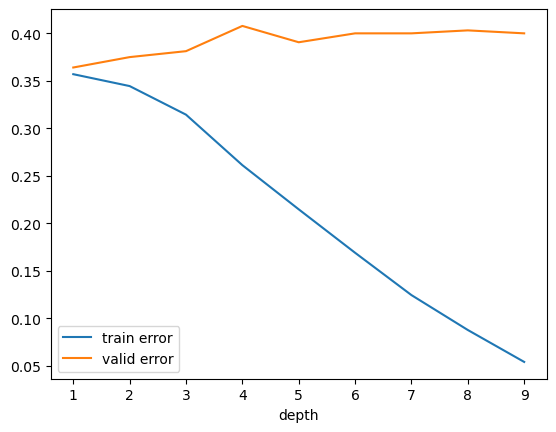

In [116]:
results = pd.DataFrame()
results['depth'] = grid['max_depth']
results['train error'] =1 - treeCV.cv_results_['mean_train_score']
results['valid error']  = 1 - treeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='depth',y='train error')
results.plot.line(x='depth',y='valid error',ax=ax1)

In [118]:
dtree = DecisionTreeClassifier(max_depth = 2)
dtree.fit(X_train, y_train)
dtree.score(X_train,y_train)

0.6390625

In [119]:
dtree_string = export_text(dtree,feature_names = list(X_train.columns),decimals = 1, spacing = 5)
print(dtree_string)

|----- CLOSE TWOS FG% RANK <= -0.8
|     |----- CLOSE TWOS FG%D RANK <= 1.3
|     |     |----- class: B
|     |----- CLOSE TWOS FG%D RANK >  1.3
|     |     |----- class: B
|----- CLOSE TWOS FG% RANK >  -0.8
|     |----- CLOSE TWOS FG% <= -0.8
|     |     |----- class: G
|     |----- CLOSE TWOS FG% >  -0.8
|     |     |----- class: G



In [120]:
cv_results = cross_validate(dtree,X_train,y_train)
acc_valid = cv_results['test_score'].mean()
print('validation accuracy rate',acc_valid)

validation accuracy rate 0.625


In [79]:
dtree.score(X_test,y_test)

0.4601728985099913

In [37]:
df.columns

Index(['Unnamed: 0', 'YEAR', 'TEAM NO', 'TEAM ID', 'TEAM', 'CONF', 'DUNKS FG%',
       'DUNKS SHARE', 'DUNKS FG%D', 'DUNKS D SHARE', 'CLOSE TWOS FG%',
       'CLOSE TWOS SHARE', 'CLOSE TWOS FG%D', 'CLOSE TWOS D SHARE',
       'FARTHER TWOS FG%', 'FARTHER TWOS SHARE', 'FARTHER TWOS FG%D',
       'FARTHER TWOS D SHARE', 'THREES FG%', 'THREES SHARE', 'THREES FG%D',
       'THREES D SHARE', 'DUNKS FG% RANK', 'DUNKS SHARE RANK',
       'DUNKS FG%D RANK', 'DUNKS D SHARE RANK', 'CLOSE TWOS FG% RANK',
       'CLOSE TWOS SHARE RANK', 'CLOSE TWOS FG%D RANK',
       'CLOSE TWOS D SHARE RANK', 'FARTHER TWOS FG% RANK',
       'FARTHER TWOS SHARE RANK', 'FARTHER TWOS FG%D RANK',
       'FARTHER TWOS D SHARE RANK', 'THREES FG% RANK', 'THREES SHARE RANK',
       'THREES FG%D RANK', 'THREES D SHARE RANK', 'SEED', 'ROUND', 'POWER',
       'PATH', 'WINS', 'POOL VALUE', 'POOL S-RANK', 'NCAA S-RANK',
       'POWER-PATH', 'rating'],
      dtype='object')

In [42]:
df['POOL VALUE']

0       2.0
1      39.0
2      91.8
3      49.6
4      51.5
       ... 
699     7.8
700     3.0
701     0.9
702     5.7
703    30.5
Name: POOL VALUE, Length: 704, dtype: float64

In [81]:
df.columns

Index(['Unnamed: 0', 'YEAR', 'TEAM NO', 'TEAM ID', 'TEAM', 'CONF', 'DUNKS FG%',
       'DUNKS SHARE', 'DUNKS FG%D', 'DUNKS D SHARE', 'CLOSE TWOS FG%',
       'CLOSE TWOS SHARE', 'CLOSE TWOS FG%D', 'CLOSE TWOS D SHARE',
       'FARTHER TWOS FG%', 'FARTHER TWOS SHARE', 'FARTHER TWOS FG%D',
       'FARTHER TWOS D SHARE', 'THREES FG%', 'THREES SHARE', 'THREES FG%D',
       'THREES D SHARE', 'DUNKS FG% RANK', 'DUNKS SHARE RANK',
       'DUNKS FG%D RANK', 'DUNKS D SHARE RANK', 'CLOSE TWOS FG% RANK',
       'CLOSE TWOS SHARE RANK', 'CLOSE TWOS FG%D RANK',
       'CLOSE TWOS D SHARE RANK', 'FARTHER TWOS FG% RANK',
       'FARTHER TWOS SHARE RANK', 'FARTHER TWOS FG%D RANK',
       'FARTHER TWOS D SHARE RANK', 'THREES FG% RANK', 'THREES SHARE RANK',
       'THREES FG%D RANK', 'THREES D SHARE RANK', 'SEED', 'ROUND', 'POWER',
       'PATH', 'WINS', 'POOL VALUE', 'POOL S-RANK', 'NCAA S-RANK',
       'POWER-PATH'],
      dtype='object')

In [ ]:
df.drop['Unnamed: 0', 'YEAR', 'TEAM NO', 'TEAM ID', 'TEAM', 'CONF', 'SEED', 'ROUND', 'POWER', 'PATH', 'POOL VALUE', 'POOL S-RANK', 'NCAA S-RANK', 'POWER-PATH']